#**ESMFold**
for more details see: [Github](https://github.com/facebookresearch/esm/tree/main/esm), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
- for homo-oligomeric predictions, set copies > 1
- See [experimental notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/ESMFold_advanced.ipynb) for more advanced options (like sampling).

#### **Colab Limitations**
- For short monomeric proteins under the length 400, consider using [ESMFold API](https://esmatlas.com/resources?action=fold) (no need for GPU, super fast!)
- On Tesla T4 (typical free colab GPU), max total length ~ 900

In [ ]:
%%time
#@title install
#@markdown install ESMFold, OpenFold and download Params (~2min 30s)
version = "1" # @param ["0", "1"]
model_name = "esmfold_v0.model" if version == "0" else "esmfold.model"
import os, time
if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")

  if not os.path.isfile("finished_install"):
    print("installing esmfold...")
    # install libs
    os.system("pip install -q omegaconf \"pytorch_lightning<2\" \"torch<2\" biopython ml_collections einops py3Dmol")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    # install openfold
    commit = "6908936b68ae89f67755240e2f588c09ec31d4c8"
    os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit}")

    # install esmfold
    os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

installing esmfold...
CPU times: user 1.21 s, sys: 170 ms, total: 1.38 s
Wall time: 5min 30s


In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "7om4_1" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "QVQLQESGGGSVQAGGSLKLTCAASGFTFDDYAIGWFRQAPGKEREGVSCISSSDGSTYYADSVKGRFTISRDNARNTVYLQMNSLKPEDTAVYYCAKDGCDYQRGIGYWGQGTQVTVSSWGQGTQVTVXS" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 131
ptm: 0.829 plddt: 85.710
CPU times: user 15.7 s, sys: 11.4 s, total: 27.1 s
Wall time: 1min 5s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

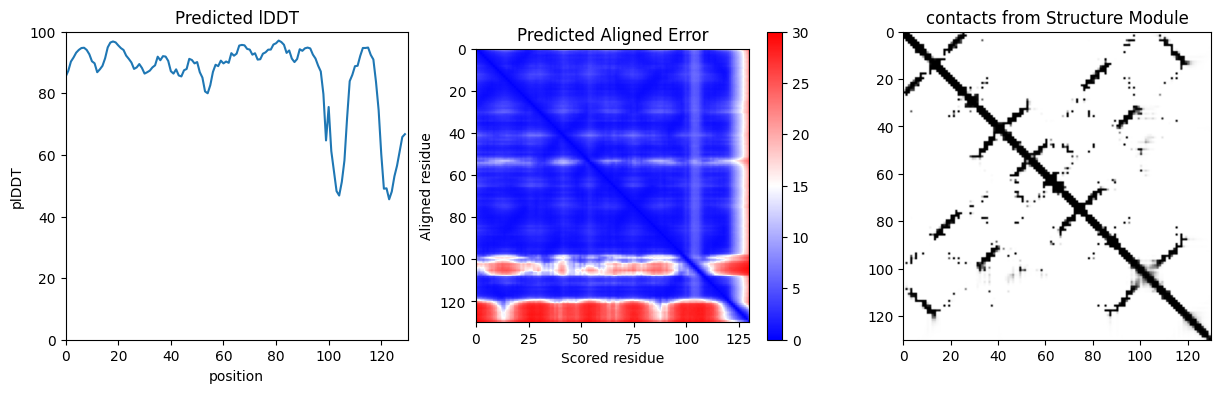

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "7om4_2" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "QVQLQESGGGSVQAGGSLKLTCVASGFTFDDYAIGWFRQAPGKEREGVSCISSSDGSTYYADSVKGRFTISRDNAKNTVYLQMNSLKSEDTAVYYCNAERTCISPYDYWGQGTQVTVSSGNWGQGTQVTVSS" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 132
ptm: 0.828 plddt: 87.772
CPU times: user 9 s, sys: 3.39 s, total: 12.4 s
Wall time: 13.1 s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

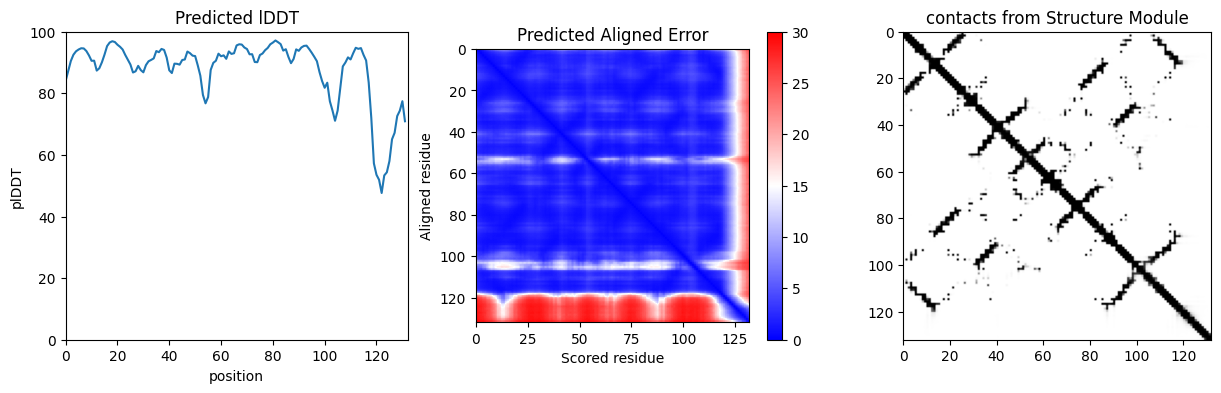

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "7om4_3" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "QVQLQESGGGSVQAGGSLKLTCTASGFTFDDYAIGWFRQAPGKEREGVSCISGSDGTTYYADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYFCAADCGLGPDGRYWGQGTQVTVSSGSWGKGTQVTVS" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 131
ptm: 0.813 plddt: 85.329
CPU times: user 9.2 s, sys: 2.69 s, total: 11.9 s
Wall time: 13.2 s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

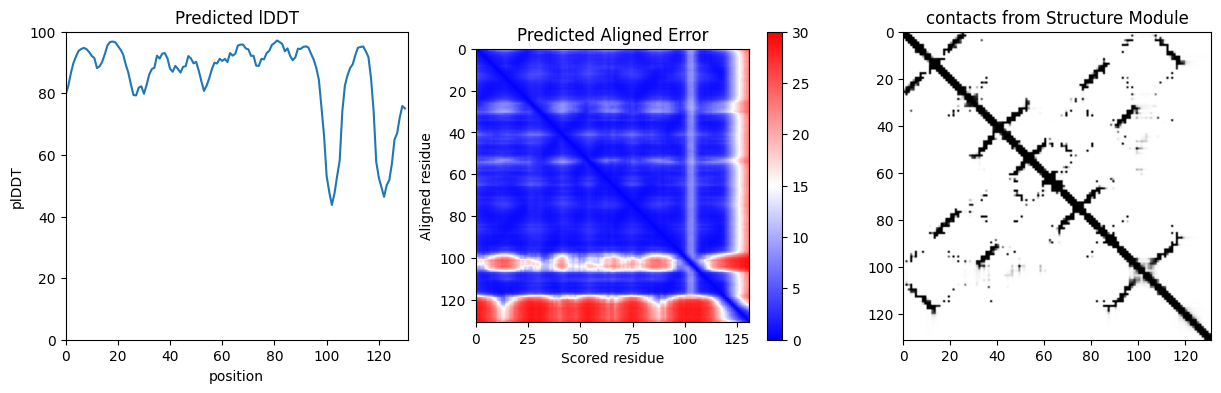

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "5jds_1" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "MAFTVTVPKDLYVVEYGSNMSMNCTSSQSALTINAMGWYRQAPGKQRELVATITTGGTTYYSDSVKGRFTISRDNAENTVYLQMNSLKPEDTAVYYCNVNVMGNGYWGQQGTWGQGTQVTVSS" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 123
ptm: 0.789 plddt: 81.348
CPU times: user 7.76 s, sys: 2.67 s, total: 10.4 s
Wall time: 10.5 s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

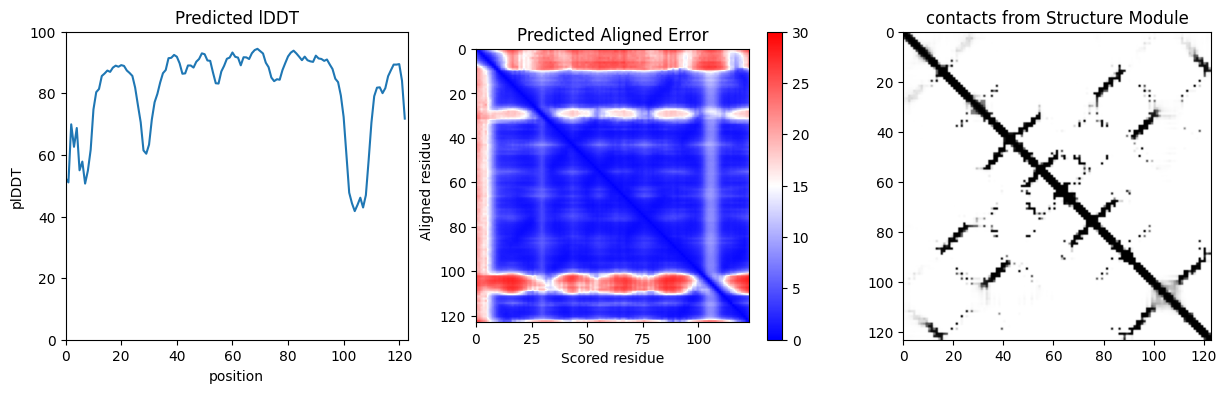

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "5jds_2" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "MAFTVTVPKDLYVVEYGSNMRVSCTASGSIFSINTMGWYRQAPGKQRELVATMSSSGSTNYADAVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYCAAGRCGTAAGSYYDVETWGEWGQGTQVTVSSNI" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 130
ptm: 0.799 plddt: 79.336
CPU times: user 9.13 s, sys: 3.07 s, total: 12.2 s
Wall time: 12.2 s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

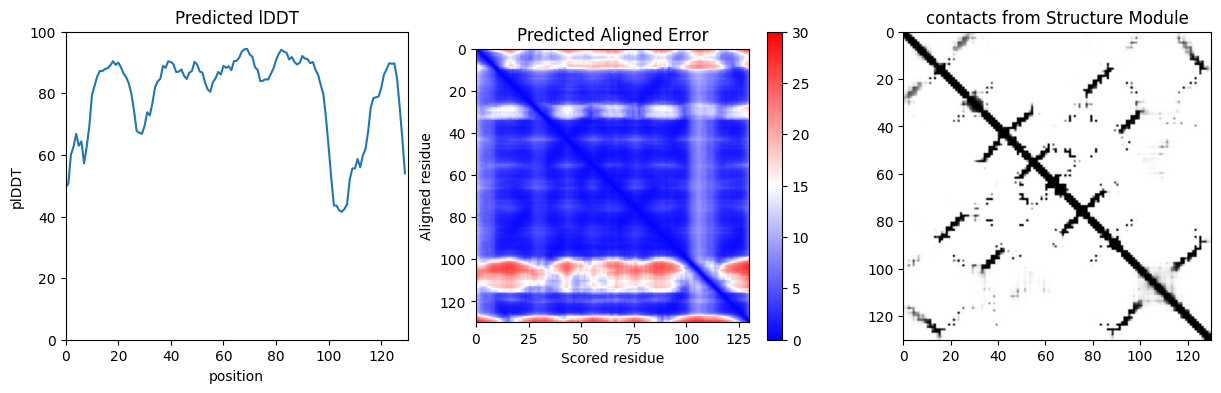

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "5jds_3" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "MAFTVTVPKDLYVVEYGSNMWLGCQSQANMSNYSVGWFRQIPGKEREGVSCISSSDGSTNYADDPVKGRFTISRDNAKNTVYLQMNSLKNEDTAVYYCAADCGSTLRYYYSDDEYEIWGQGTQVTVSS" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 128
ptm: 0.762 plddt: 73.826
CPU times: user 7.99 s, sys: 3.13 s, total: 11.1 s
Wall time: 11.1 s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

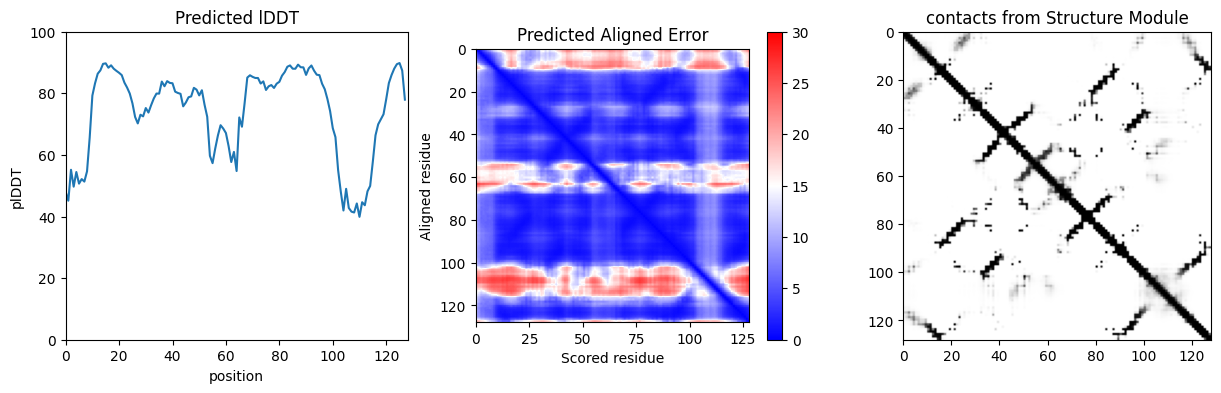

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "5dxw_1" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "MAQVQLVETGGGLVQPGGSLRLSCAASGFTFDDYAIGWFRQAPGKEREGVSCISSSDGSTYYADSVKGRFTISRDNAKNTVYLQMNNLKPEDTAVYYCNADGLRDRHRGYWGQGTQVTVSVSS" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 123
ptm: 0.854 plddt: 86.291
CPU times: user 7.67 s, sys: 2.75 s, total: 10.4 s
Wall time: 10.5 s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

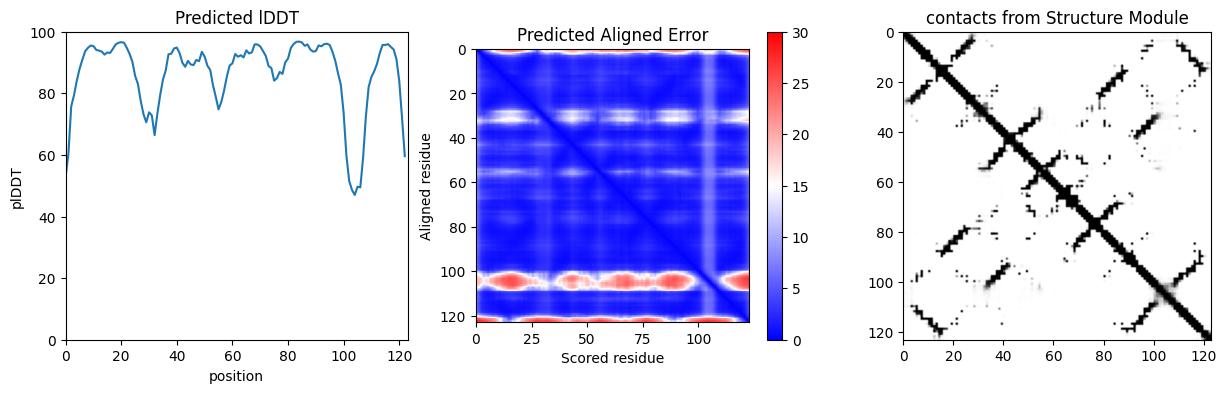

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "5dxw_2" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "MAQVQLVETGGGLVQPGGSLRLSCAASGFTFDDYAIGWFRQAPGKEREGVSCISSSDGSTSYADSNVKGRFTISRDNAKNTVYLQMNSLKSEDTAVYYCARGKYDWGSQGMDYWGKGTQVTVSSDF" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 126
ptm: 0.867 plddt: 87.085
CPU times: user 8.01 s, sys: 3.03 s, total: 11 s
Wall time: 11.1 s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

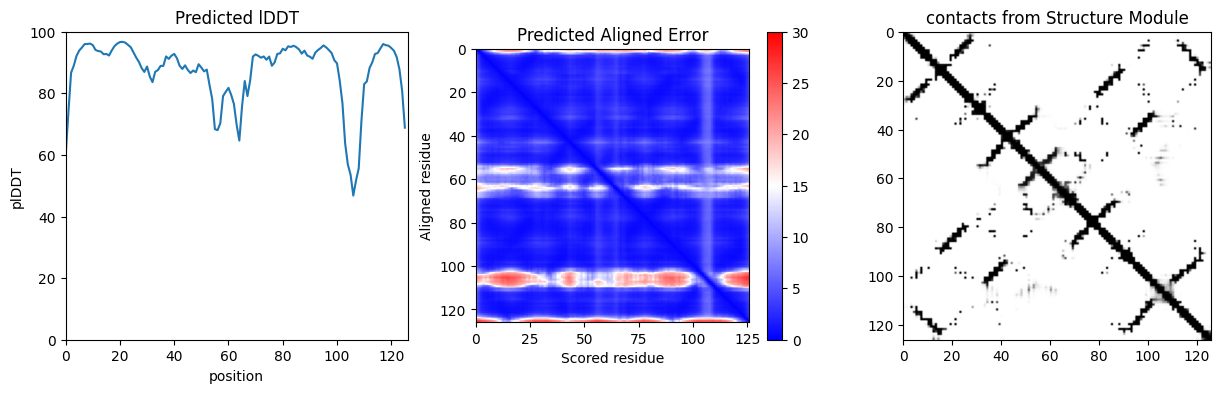

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "5dxw_3" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "MAQVQLVETGGGLVQPGGSLRLSCAASGFTLDYYAIGWFRQAPGKEREGVSCISSSDGNTYYADSVKGRFTISRDNAKNTVYLQMNSLKPDDTAVYFCATRTVFGYDYWGQGTQVTVSSDPLWGQGTQVTVSS" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 12 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 133
ptm: 0.809 plddt: 84.258
CPU times: user 9.54 s, sys: 3.65 s, total: 13.2 s
Wall time: 13.3 s


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

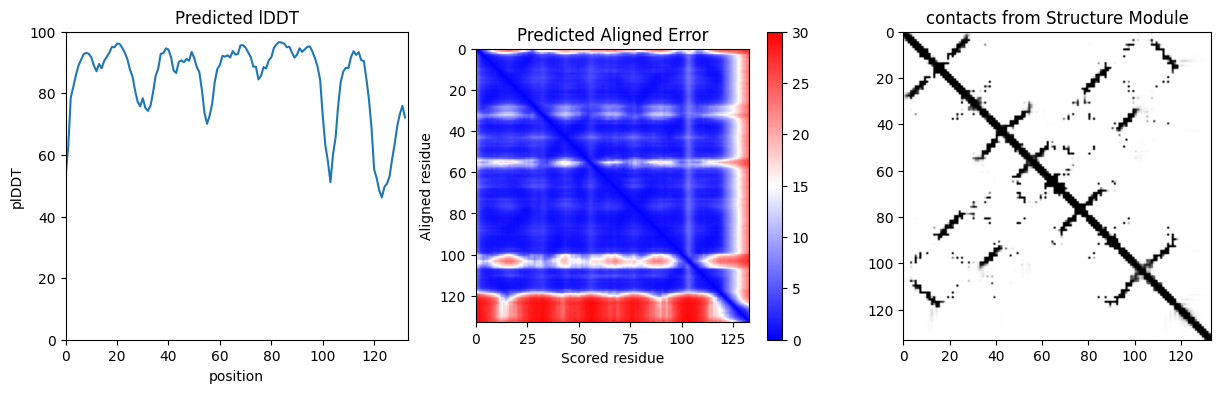

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>